# Analyse van populariteit, verkoop en gebruikersbeoordelingen van videogames

In dit notebook gebruik ik Apache Spark om drie datasets (Steam Reviews, Steam Metadata en Video Game Sales) te analyseren en te visualiseren.


# Data voorbereiden

## Spark-omgeving opzetten

In [1]:
from pyspark.sql import SparkSession

# SparkSession aanmaken
spark = SparkSession.builder \
    .appName("GameAnalysis") \
    .getOrCreate()

# Check: welke Spark versie?
print("Spark version:", spark.version)


Spark version: 3.5.0


## Datasets inlezen

In [2]:
data_path = "../data/"

# Bestandsnamen
reviews_file = data_path + "dataset.csv"     # Steam reviews
steam_file   = data_path + "steam.csv"       # Steam metadata
sales_file   = data_path + "vgsales.csv"     # Video game sales


# Data inlezen met Spark
reviews_df = spark.read.csv(reviews_file, header=True, inferSchema=True)
steam_df   = spark.read.csv(steam_file,   header=True, inferSchema=True)
sales_df   = spark.read.csv(sales_file,   header=True, inferSchema=True)

# bevestiging inlezen
print("Reviews DF ingelezen:", reviews_df.count(), "rijen")
print("Steam metadata DF ingelezen:", steam_df.count(), "rijen")
print("Sales DF ingelezen:", sales_df.count(), "rijen")

Reviews DF ingelezen: 6417106 rijen
Steam metadata DF ingelezen: 27075 rijen
Sales DF ingelezen: 16598 rijen


In [3]:
# Eerste rijen bekijken
print("Steam Reviews:")
reviews_df.show(5, truncate=False)

print("\nSteam Metadata:")
steam_df.show(5, truncate=False)

print("\nVideo Game Sales:")
sales_df.show(5, truncate=False)

Steam Reviews:
+------+--------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Kolomnamen checken

In [4]:
print("Reviews kolommen:", reviews_df.columns)
print("Steam kolommen:", steam_df.columns)
print("Sales kolommen:", sales_df.columns)

Reviews kolommen: ['app_id', 'app_name', 'review_text', 'review_score', 'review_votes']
Steam kolommen: ['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price']
Sales kolommen: ['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']


## Schema's bekijken

In [5]:
print("Schema Steam Reviews:")
reviews_df.printSchema()

print("\nSchema Steam Metadata:")
steam_df.printSchema()

print("\nSchema Video Game Sales:")
sales_df.printSchema()

Schema Steam Reviews:
root
 |-- app_id: integer (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- review_votes: integer (nullable = true)


Schema Steam Metadata:
root
 |-- appid: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- english: string (nullable = true)
 |-- developer: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- platforms: string (nullable = true)
 |-- required_age: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- steamspy_tags: string (nullable = true)
 |-- achievements: string (nullable = true)
 |-- positive_ratings: string (nullable = true)
 |-- negative_ratings: integer (nullable = true)
 |-- average_playtime: integer (nullable = true)
 |-- median_playtime: integer (nullable = true)
 |-- owners: string (nullable = true)
 |-- p

## Controleren op missing values

In [6]:
from pyspark.sql.functions import col, sum as spark_sum

def count_missing(df):
    return df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

print("Missing values: Reviews")
count_missing(reviews_df).show()

print("\nMissing values: Steam Metadata")
count_missing(steam_df).show()

print("\nMissing values: Video Game Sales")
count_missing(sales_df).show()

Missing values: Reviews
+------+--------+-----------+------------+------------+
|app_id|app_name|review_text|review_score|review_votes|
+------+--------+-----------+------------+------------+
|     0|  183234|       7305|         289|         289|
+------+--------+-----------+------------+------------+


Missing values: Steam Metadata
+-----+----+------------+-------+---------+---------+---------+------------+----------+------+-------------+------------+----------------+----------------+----------------+---------------+------+-----+
|appid|name|release_date|english|developer|publisher|platforms|required_age|categories|genres|steamspy_tags|achievements|positive_ratings|negative_ratings|average_playtime|median_playtime|owners|price|
+-----+----+------------+-------+---------+---------+---------+------------+----------+------+-------------+------------+----------------+----------------+----------------+---------------+------+-----+
|    0|   0|           0|      0|        0|        0|    

#### Conclusie – Missing values

- In de **Steam Reviews** dataset zitten geen ontbrekende `app_id`–waarden, maar wel een beperkt aantal missende `app_name`, `review_text`, `review_score` en `review_votes`. Dat betekent dat we de reviews nog veilig per game (`appid`) kunnen aggregeren, maar dat sommige individuele reviewvelden onvolledig zijn.
- De **Steam Metadata** en **Video Game Sales** datasets hebben **geen missing values** in de belangrijkste kolommen. Deze twee tabellen zijn dus meteen bruikbaar voor joins en aggregaties.
- In het verdere verloop van het notebook behandel ik de missende reviewveciet door op gameniveau te werken (aggregaties per `appid`), niet op individueel review-nivau.


# Kolomen proper maken

## Steam reviews

In [7]:
# Kleine opschoning + renaming
reviews_clean = reviews_df \
    .withColumnRenamed("app_id", "appid")

print("Aantal rijen reviews (clean):", reviews_clean.count())
reviews_clean.show(5)

Aantal rijen reviews (clean): 6417106
+-----+--------------+--------------------+------------+------------+
|appid|      app_name|         review_text|review_score|review_votes|
+-----+--------------+--------------------+------------+------------+
|   10|Counter-Strike|     Ruined my life.|           1|           0|
|   10|Counter-Strike|This will be more...|           1|           1|
|   10|Counter-Strike|This game saved m...|           1|           0|
|   10|Counter-Strike|• Do you like ori...|           1|           0|
|   10|Counter-Strike|        Easy to l...|           1|           1|
+-----+--------------+--------------------+------------+------------+
only showing top 5 rows



## Steam metadata

In [8]:
from pyspark.sql.functions import regexp_replace, to_date

steam_clean = steam_df

# release_date -> date
steam_clean = steam_clean.withColumn(
    "release_date",
    to_date(col("release_date"), "yyyy-MM-dd")
)

# price -> numeriek
steam_clean = steam_clean.withColumn(
    "price",
    regexp_replace("price", "[$€,]", "").cast("double")
)

# positive_ratings -> integer
steam_clean = steam_clean.withColumn(
    "positive_ratings",
    col("positive_ratings").cast("int")
)

print("Steam metadata cleaned:")
steam_clean.select("appid", "name", "release_date", "price", "positive_ratings").show(5, truncate=False)


Steam metadata cleaned:
+-----+-------------------------+------------+-----+----------------+
|appid|name                     |release_date|price|positive_ratings|
+-----+-------------------------+------------+-----+----------------+
|10   |Counter-Strike           |2000-11-01  |7.19 |124534          |
|20   |Team Fortress Classic    |1999-04-01  |3.99 |3318            |
|30   |Day of Defeat            |2003-05-01  |3.99 |3416            |
|40   |Deathmatch Classic       |2001-06-01  |3.99 |1273            |
|50   |Half-Life: Opposing Force|1999-11-01  |3.99 |5250            |
+-----+-------------------------+------------+-----+----------------+
only showing top 5 rows



## Video Game Sales

In [9]:
sales_clean = sales_df.withColumn("Year", col("Year").cast("int"))

print("Sales dataset cleaned:")
sales_clean.show(5)


Sales dataset cleaned:
+----+--------------------+--------+----+------------+---------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+---------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports| Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform| Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing| Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports| Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing| Nintendo|   11.27|    8.89|   10.22|        1.0|       31.37|
+----+--------------------+--------+----+

## final check

In [10]:
print("Aantal unieke appid in reviews:", reviews_clean.select("appid").distinct().count())
print("Aantal unieke appid in steam:", steam_clean.select("appid").distinct().count())

print("Aantal unieke game names in sales:", sales_clean.select("Name").distinct().count())
print("Aantal unieke names in steam:", steam_clean.select("name").distinct().count())

Aantal unieke appid in reviews: 9972
Aantal unieke appid in steam: 27075
Aantal unieke game names in sales: 11493
Aantal unieke names in steam: 27033


# Aggregaties

## steam reviews

In [11]:
from pyspark.sql.functions import sum as spark_sum, count

# Aantal reviews per appid + ratio positief
reviews_agg = reviews_clean.groupBy("appid").agg(
    count("*").alias("total_reviews"),
    spark_sum("review_score").alias("positive_reviews")
)

# Negatieve berekenen
reviews_agg = reviews_agg.withColumn(
    "negative_reviews",
    (col("total_reviews") - col("positive_reviews"))
)

# Ratio positief
reviews_agg = reviews_agg.withColumn(
    "positive_ratio",
    (col("positive_reviews") / col("total_reviews"))
)

reviews_agg.show(10)


+------+-------------+----------------+----------------+-------------------+
| appid|total_reviews|positive_reviews|negative_reviews|     positive_ratio|
+------+-------------+----------------+----------------+-------------------+
|111300|           17|              11|               6| 0.6470588235294118|
| 10230|           56|             -28|              84|               -0.5|
| 11280|          451|             341|             110| 0.7560975609756098|
| 15100|         1940|            1180|             760| 0.6082474226804123|
| 16500|            6|               2|               4| 0.3333333333333333|
| 19200|          198|              76|             122| 0.3838383838383838|
|108500|          317|             249|              68| 0.7854889589905363|
|200130|          120|              74|              46| 0.6166666666666667|
|105300|          200|             104|              96|               0.52|
| 12210|        14401|            2444|           11957|0.16971043677522393|

#### Conclusie – Aggregatie Steam Reviews

- Voor elke `appid` heb ik nu een samenvatting met:
  - `total_reviews`: het aantal reviews,
  - `positive_reviews` en `negative_reviews`,
  - `positive_ratio`: de verhouding tussen positieve en totale reviews.
- Deze tabel vat de subjectieve spelerstevredenheid per game samen. Games met een hoge `positive_ratio` worden gemiddeld beter ontvangen dan games met een lage of negatieve ratio.
- Deze aggregatie vormt de basis om later te onderzoeken of **spelerstevredenheid** (reviews) samenhangt met **verkoopcijfers** en **prijs**.

## steam metadata

### Games per genre

In [12]:
from pyspark.sql.functions import split, explode

genres_exploded = steam_clean.withColumn(
    "genre_split",
    split(col("genres"), ";")
).withColumn(
    "genre",
    explode(col("genre_split"))
)

games_per_genre = genres_exploded.groupBy("genre").count().orderBy("count", ascending=False)

games_per_genre.show(15)


+--------------------+-----+
|               genre|count|
+--------------------+-----+
|               Indie|19419|
|              Action|11903|
|              Casual|10210|
|           Adventure|10031|
|            Strategy| 5246|
|          Simulation| 5194|
|                 RPG| 4310|
|        Early Access| 2954|
|        Free to Play| 1704|
|              Sports| 1322|
|              Racing| 1024|
|             Violent|  843|
|Massively Multipl...|  723|
|                Gore|  537|
|              Nudity|  266|
+--------------------+-----+
only showing top 15 rows



#### Conclusie – Aantal games per genre (Steam catalogus)

- De Steam-catalogus wordt duidelijk **gedomineerd door Indie, Action, Casual  n Adventure**. Deze genres hebben veruit de grootste aantallen games.
- Niche-tags zoals `Violent`, `Gore`, `Nudity` en `Massively Multiplayer` komen veel minder vaak voor.Dk: dit zegt **iets over het aanbod op Steam**, niet over de kwaliteit of verkoop. Er zijn veel Indie-games, maar die verkopen niet noodzakelijk het bst.


### Gemiddelde prijs per genre

In [37]:
avg_price_per_genre = genres_exploded.groupBy("genre").agg(
    {"price": "avg"}
).withColumnRenamed("avg(price)", "avg_price")

avg_price_per_genre.orderBy("avg_price").show(30)

+--------------------+-------------------+
|               genre|          avg_price|
+--------------------+-------------------+
|         Steam Cloud|               NULL|
|Full controller s...|               NULL|
|       Single-player|               NULL|
|  Steam Achievements|               NULL|
|  Steam Leaderboards|               NULL|
|        Free to Play|0.09916666666666668|
|          Accounting|               2.91|
|         Documentary|               3.98|
|            Tutorial|               3.98|
|              Casual|  4.106194906954172|
|Massively Multipl...| 4.3201106500691555|
|               Indie| 5.0498213090271244|
|                Gore|  5.972104283053996|
|           Adventure|  6.122012760442753|
|              Action| 6.1403688145845265|
|             Violent|  6.228351126927603|
|      Sexual Content|  6.846612244897962|
|                 RPG|  6.942136890951362|
|            Strategy|  6.944552039649489|
|        Early Access|  7.039631008801581|
|          

#### Conclusie – Gemiddelde prijs per genre

- Sommige rijen met `NULL` horen eigenlijk bij **feature-tags** (bv. “Steam Achievements”, “Single-player”) en zijn geen echte genres. Deze gebruik ik enkel ter observatie, niet voor interpretatie.
- Genres zoals **Free to Play** hebben, zoals verwacht, bijna **nul gemiddelde prijs**.
- Genres zoals **Casual, Indie en Massively Multiplayer** zitten eerder in het lagere prijssegment, terwijl sommige andere genres gemiddeld iets duurder zijn.
- Dit suggereert dat prijsniveau ook genre-afhankelijk is: niet elk type game wordt op dezelfde manier geprjsd.


### top games (ratings)

In [14]:
top_rated_games = steam_clean.orderBy(col("positive_ratings").desc()).select(
    "appid", "name", "positive_ratings"
)

top_rated_games.show(10, truncate=False)


+------+--------------------------------+----------------+
|appid |name                            |positive_ratings|
+------+--------------------------------+----------------+
|730   |Counter-Strike: Global Offensive|2644404         |
|570   |Dota 2                          |863507          |
|440   |Team Fortress 2                 |515879          |
|578080|PLAYERUNKNOWN'S BATTLEGROUNDS   |496184          |
|4000  |Garry's Mod                     |363721          |
|271590|Grand Theft Auto V              |329061          |
|218620|PAYDAY 2                        |308657          |
|304930|Unturned                        |292574          |
|105600|Terraria                        |255600          |
|550   |Left 4 Dead 2                   |251789          |
+------+--------------------------------+----------------+
only showing top 10 rows



#### Conclusie – Populairste games op Steam (positive_ratings)

- De top van de lijst wordt gedomineerd door **CS:GO, Dota 2, Team Fortress 2, PUBG, Garry’s Mod, GTA V, PAYDAY 2, Unturned, Terraria, Left 4 Dead 2** enz.
- Dit zijn bijna allemaal **grote multiplayer- of live-service games** die jarenlang actief gespeeld worden en daardoor enorm veel positieve reviews hebben opgebouwd.
- Deze kolom toont vooral **populariteit op Steam (engagement)**, niet direct kwalitkop.


## Video game sales

### totaal verkoop per genre

In [15]:
sales_per_genre = sales_clean.groupBy("Genre").agg(
    {"Global_Sales": "sum"}
).withColumnRenamed("sum(Global_Sales)", "total_sales")

sales_per_genre.orderBy("total_sales", ascending=False).show(15)


+------------+------------------+
|       Genre|       total_sales|
+------------+------------------+
|      Action|1751.1799999999691|
|      Sports| 1330.929999999988|
|     Shooter|1037.3699999999901|
|Role-Playing| 927.3699999999941|
|    Platform| 831.3699999999974|
|        Misc| 809.9599999999936|
|      Racing| 732.0399999999955|
|    Fighting|448.90999999999923|
|  Simulation|392.19999999999783|
|      Puzzle| 244.9500000000005|
|   Adventure|239.04000000000138|
|    Strategy| 175.1200000000004|
+------------+------------------+



#### Conclusie – Globale verkoop per genre (VGsales)

- In de globale verkoopdata (console + PC) zien we dat **Action** en **Sports** veruit de grootste totale verkoop realiseren.
- **Shooter**, **Role-Playing** en **Platform** vormen een tweede sterke groep, terwijl genres zoals **Puzzle, Adventure en Strategy** duidelijk kleiner zijn.
- Dit bevestigt dat de **massamarkt vooral gedreven wordt door actiegerichte games en sporttitels**, zelfs als andere genres mogelijk hogere review-scores heben.


### Verkoop per jaar

In [43]:
sales_per_year = sales_clean.groupBy("Year").agg(
    {"Global_Sales": "sum"}
).withColumnRenamed("sum(Global_Sales)", "total_sales")

sales_per_year.orderBy("Year").show(40)


+----+------------------+
|Year|       total_sales|
+----+------------------+
|NULL|100.07999999999994|
|1980|11.379999999999999|
|1981| 35.77000000000001|
|1982|28.859999999999996|
|1983|16.790000000000003|
|1984|50.360000000000014|
|1985|53.940000000000005|
|1986|             37.07|
|1987|21.739999999999995|
|1988|             47.22|
|1989|             73.45|
|1990| 49.38999999999999|
|1991|32.230000000000004|
|1992| 76.15999999999998|
|1993|             45.98|
|1994| 79.17000000000003|
|1995| 88.10999999999991|
|1996|199.14999999999995|
|1997|200.98000000000013|
|1998|256.46999999999963|
|1999|251.27000000000018|
|2000| 201.5600000000002|
|2001| 331.4699999999991|
|2002| 395.5199999999983|
|2003| 357.8499999999989|
|2004|419.30999999999864|
|2005| 459.9399999999976|
|2006| 521.0399999999917|
|2007| 611.1299999999934|
|2008| 678.8999999999952|
|2009| 667.2999999999947|
|2010| 600.4499999999948|
|2011| 515.9899999999969|
|2012| 363.5399999999984|
|2013|368.10999999999865|
|2014| 337.0

#### Conclusie – Verkoop per jaar (VGsales)

- De globale verkoop evolueert duidelijk over de jaren heen: vanaf de jaren ’80 neemt de totale verkoop toe, met sterkere stijgingen in de jaren ’90 en 20n).
- Het `NULL`-jaar duidt op games waarbij het jaar niet eenduidig in de bron vermeld wordt (bijvoorbeeld bundels of onvolledige records). Deze rijen zijn beperkt en verstoren de algemene trend niet.
- Deze analyse toont de **groei van de gamesmarkt doorheen de tijd**, maar in de rest van het notebook focus ik op de subset die zowel een Steam-entry als verkoopcijfers heft.


### Top publishers

In [17]:
top_publishers = sales_clean.groupBy("Publisher").agg(
    {"Global_Sales": "sum"}
).withColumnRenamed("sum(Global_Sales)", "total_sales")

top_publishers.orderBy("total_sales", ascending=False).show(10, truncate=False)


+----------------------------+------------------+
|Publisher                   |total_sales       |
+----------------------------+------------------+
|Nintendo                    |1786.5599999999981|
|Electronic Arts             |1110.3199999999915|
|Activision                  |727.4599999999983 |
|Sony Computer Entertainment |607.4999999999989 |
|Ubisoft                     |474.71999999999935|
|Take-Two Interactive        |399.5399999999996 |
|THQ                         |340.7699999999994 |
|Konami Digital Entertainment|283.639999999998  |
|Sega                        |272.98999999999927|
|Namco Bandai Games          |254.0900000000008 |
+----------------------------+------------------+
only showing top 10 rows



#### Conclusie – Belangrijkste uitgevers

- **Nintendo** steekt er duidelijk bovenuit als grootste publisher in termen van totale globale verkoop.
- Daarna volgen grote namen zoals **Electronic Arts, Activision, Sony Computer Entertainment, Ubisoft, Take-Two Interactive**, enz.
- Deze verdeling toont dat een relatief kleine groep **AAA-publishers** verantwoordelijk is voor een groot deel van de commerciële markt.

# JOIN pairs

## Steam Reviews <-> Steam Metadata

In [18]:
# Reviews + steam metadata combineren via appid
reviews_with_metadata = reviews_agg.join(
    steam_clean,
    on="appid",
    how="inner"
)

reviews_with_metadata.select(
    "appid", "name", "total_reviews", "positive_ratio", "price", "genres", "release_date"
).show(10, truncate=False)


+------+-----------------------------------------+-------------+-------------------+-----+-------------------------+------------+
|appid |name                                     |total_reviews|positive_ratio     |price|genres                   |release_date|
+------+-----------------------------------------+-------------+-------------------+-----+-------------------------+------------+
|10230 |Dead Mountaineer's Hotel                 |56           |-0.5               |5.59 |Adventure                |2011-10-28  |
|11280 |Penguins Arena: Sedna's World            |451          |0.7560975609756098 |4.79 |Action;Casual;Indie      |2008-12-18  |
|15100 |Assassin's Creed™: Director's Cut Edition|1940         |0.6082474226804123 |8.59 |Action;Adventure         |2008-04-09  |
|16500 |Chaos Theory                             |6            |0.3333333333333333 |1.99 |Casual;Indie             |2008-05-22  |
|19200 |Tank Universal                           |198          |0.3838383838383838 |3.99 |

#### Conclusie – Koppeling reviews en Steam-metadata

- Door de review-aggregaties te joinen met de Steam-metadata (via `appid`) heb ik nu per game:
  - hoeveel reviews er zijn,
  - hoe positief ze gemiddeld zijn (`positive_ratio`),
  - welke prijs en genres bij het spel horen,
  - en de release-datum.
- Dit vormt een eerste geïntegreerde tabel waarmee ik **spelerstevredenheid** kan linken aan **producteigenschappen** zoals genre, prijs en releaejaar.


## Steam Metadata <-> Video Game Sales

### namen normaliseren

In [19]:
from pyspark.sql.functions import lower, trim, year

steam_normalized = steam_clean.withColumn(
    "name_norm",
    trim(lower(col("name")))
).withColumn(
    "release_year",
    year(col("release_date"))
)

sales_normalized = sales_clean.withColumn(
    "name_norm",
    trim(lower(col("Name")))
)


### Join op naam

In [20]:
##alias omdat je anders twee kolommen met dezelfde naam hebt
steam_alias = steam_normalized.alias("steam")
sales_alias = sales_normalized.alias("sales")

metadata_sales_join = steam_alias.join(
    sales_alias,
    on="name_norm",
    how="inner"
)

metadata_sales_join.select(
    "name_norm",
    "steam.name",
    "sales.Year",
    "steam.release_year",
    "sales.Global_Sales",
    "sales.Platform"
).show(20, truncate=False)


+----------------------+----------------------+----+------------+------------+--------+
|name_norm             |name                  |Year|release_year|Global_Sales|Platform|
+----------------------+----------------------+----+------------+------------+--------+
|counter-strike        |Counter-Strike        |2003|2000        |1.11        |XB      |
|half-life             |Half-Life             |2001|1998        |0.6         |PS2     |
|half-life             |Half-Life             |1997|1998        |4.12        |PC      |
|half-life 2           |Half-Life 2           |2005|2004        |0.61        |XB      |
|half-life 2           |Half-Life 2           |2004|2004        |2.37        |PC      |
|counter-strike: source|Counter-Strike: Source|2004|2004        |0.09        |PC      |
|left 4 dead           |Left 4 Dead           |2008|2008        |0.02        |PC      |
|left 4 dead           |Left 4 Dead           |2008|2008        |3.52        |X360    |
|left 4 dead 2         |Left 4 D

### join op naam en release jaar

In [21]:
from pyspark.sql.functions import col

# Aliassen maken voor duidelijkheid
steam_alias = steam_normalized.alias("steam")
sales_alias = sales_normalized.alias("sales")

# Join op genormaliseerde naam + hetzelfde jaar
metadata_sales_join_year = steam_alias.join(
    sales_alias,
    (col("steam.name_norm") == col("sales.name_norm")) &
    (col("steam.release_year") == col("sales.Year")),
    how="inner"
)

metadata_sales_join_year.select(
    col("steam.appid"),
    col("steam.name").alias("steam_name"),
    col("sales.Name").alias("sales_name"),
    col("sales.Year"),
    col("steam.release_year"),
    col("steam.price"),
    col("steam.genres"),
    col("sales.Global_Sales"),
    col("sales.Platform")
).show(20, truncate=False)


+-----+-----------------------------------+-----------------------------------+----+------------+-----+-----------------------------------+------------+--------+
|appid|steam_name                         |sales_name                         |Year|release_year|price|genres                             |Global_Sales|Platform|
+-----+-----------------------------------+-----------------------------------+----+------------+-----+-----------------------------------+------------+--------+
|220  |Half-Life 2                        |Half-Life 2                        |2004|2004        |7.19 |Action                             |2.37        |PC      |
|240  |Counter-Strike: Source             |Counter-Strike: Source             |2004|2004        |7.19 |Action                             |0.09        |PC      |
|500  |Left 4 Dead                        |Left 4 Dead                        |2008|2008        |7.19 |Action                             |0.02        |PC      |
|500  |Left 4 Dead          

#### Conclusie – Koppeling Steam-games met verkoopcijfers

- De koppeling tussen Steam en de verkoopdataset gebeurt op **genormaliseerde naam** én **releasejaar**. Dit is nodig omdat:
  - titels in beide datasets soms licht verschillen,
  - dezelfde titel op meerdere platformen of in meerdere jaren kan voorkomen.
- Door te joinen op `name_norm` + `release_year` krijg ik per game één of meerdere verkooprecords (per platform), die ik later zal optellen tot één `total_global_sales`.
- Deze stap is cruciaal om **Steam-data (reviews + metadata)** en **commerciële verkoopcijfers** met elkaar te verbnden.


## JOIN results

### metadata_sales_join_year cleanen

In [22]:
# -> reduceren naar een versie met unieke kolomnamen
metadata_sales_join_year_clean = metadata_sales_join_year.select(
    col("steam.appid").alias("appid"),
    col("steam.name").alias("steam_name"),
    col("sales.Name").alias("sales_name"),
    col("steam.genres").alias("genres"),
    col("steam.price").alias("price"),
    col("sales.Global_Sales").alias("global_sales"),
    col("sales.Platform").alias("platform"),
    col("steam.release_year").alias("release_year")
)

print("Kolommen van metadata_sales_join_year_clean:")
print(metadata_sales_join_year_clean.columns)

metadata_sales_join_year_clean.show(10, truncate=False)


Kolommen van metadata_sales_join_year_clean:
['appid', 'steam_name', 'sales_name', 'genres', 'price', 'global_sales', 'platform', 'release_year']
+-----+----------------------+----------------------+--------------------------+-----+------------+--------+------------+
|appid|steam_name            |sales_name            |genres                    |price|global_sales|platform|release_year|
+-----+----------------------+----------------------+--------------------------+-----+------------+--------+------------+
|220  |Half-Life 2           |Half-Life 2           |Action                    |7.19 |2.37        |PC      |2004        |
|240  |Counter-Strike: Source|Counter-Strike: Source|Action                    |7.19 |0.09        |PC      |2004        |
|500  |Left 4 Dead           |Left 4 Dead           |Action                    |7.19 |0.02        |PC      |2008        |
|500  |Left 4 Dead           |Left 4 Dead           |Action                    |7.19 |3.52        |X360    |2008        |


### reviews_with_metadata renaming

In [23]:
reviews_final = reviews_with_metadata.select(
    col("appid").alias("appid"),
    col("name").alias("steam_name_reviews"),
    col("total_reviews"),
    col("positive_ratio")
)


### Final JOIN

In [24]:
rev_alias = reviews_final.alias("rev")
ms_alias = metadata_sales_join_year_clean.alias("ms")

final_df = rev_alias.join(
    ms_alias,
    on="appid",
    how="inner"
)

print("Aantal rijen in final_df:", final_df.count())

final_df.select(
    "appid",
    "steam_name_reviews",
    "steam_name",
    "sales_name",
    "genres",
    "price",
    "total_reviews",
    "positive_ratio",
    "global_sales",
    "platform",
    "release_year"
).show(20, truncate=False)


Aantal rijen in final_df: 449
+------+-----------------------------------+-----------------------------------+-----------------------------------+--------------------------+-----+-------------+-------------------+------------+--------+------------+
|appid |steam_name_reviews                 |steam_name                         |sales_name                         |genres                    |price|total_reviews|positive_ratio     |global_sales|platform|release_year|
+------+-----------------------------------+-----------------------------------+-----------------------------------+--------------------------+-----+-------------+-------------------+------------+--------+------------+
|12210 |Grand Theft Auto IV                |Grand Theft Auto IV                |Grand Theft Auto IV                |Action;Adventure          |19.99|14401        |0.16971043677522393|11.02       |X360    |2008        |
|12210 |Grand Theft Auto IV                |Grand Theft Auto IV                |Grand Theft Au

### globale sales ipv per platfrom

In [25]:
from pyspark.sql.functions import sum as spark_sum, first

# Totale sales per game + retain game-level info
final_game_df = final_df.groupBy("appid").agg(
    spark_sum("global_sales").alias("total_global_sales"),
    first("steam_name_reviews").alias("steam_name"),
    first("genres").alias("genres"),
    first("price").alias("price"),
    first("total_reviews").alias("total_reviews"),
    first("positive_ratio").alias("positive_ratio"),
    first("release_year").alias("release_year")
)

print("Aantal unieke games in final_game_df:", final_game_df.count())

final_game_df.show(20, truncate=False)


Aantal unieke games in final_game_df: 208
+-----+------------------+-----------------------------------+-----------------------------------+-----+-------------+--------------------+------------+
|appid|total_global_sales|steam_name                         |genres                             |price|total_reviews|positive_ratio      |release_year|
+-----+------------------+-----------------------------------+-----------------------------------+-----+-------------+--------------------+------------+
|220  |2.37              |Half-Life 2                        |Action                             |7.19 |6483         |0.999074502545118   |2004        |
|240  |0.09              |Counter-Strike: Source             |Action                             |7.19 |17571        |0.8979568607364408  |2004        |
|500  |3.54              |Left 4 Dead                        |Action                             |7.19 |4706         |0.8767530811729707  |2008        |
|550  |4.36              |Left 4 Dead 2 

### Conclusie – Finale game-tabel (final_game_df)

- In `final_game_df` zijn alle platform-specifieke sales samengevoegd tot één **`total_global_sales` per Steam-game**.
- Voor elke game heb ik nu:
  - totale wereldwijde verkoop,
  - Steam-naam en genres,
  - prijs,
  - aantal reviews en `positive_ratio`,
  - het releasejaar.
- De finale dataset bevat **208 unieke games** die in alle drie de bronnen voorkomen. Dit is een relatief kleine, maar kwalitatieve subset van vaak grotere multi-platform titels.
- Alle verdere visualisaties en correlaties zijn gebaseerd op deze geïntegreede tabel.


# Visualisaties

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql.functions import col, sum as spark_sum, count, split, explode

## Verkoop per genre

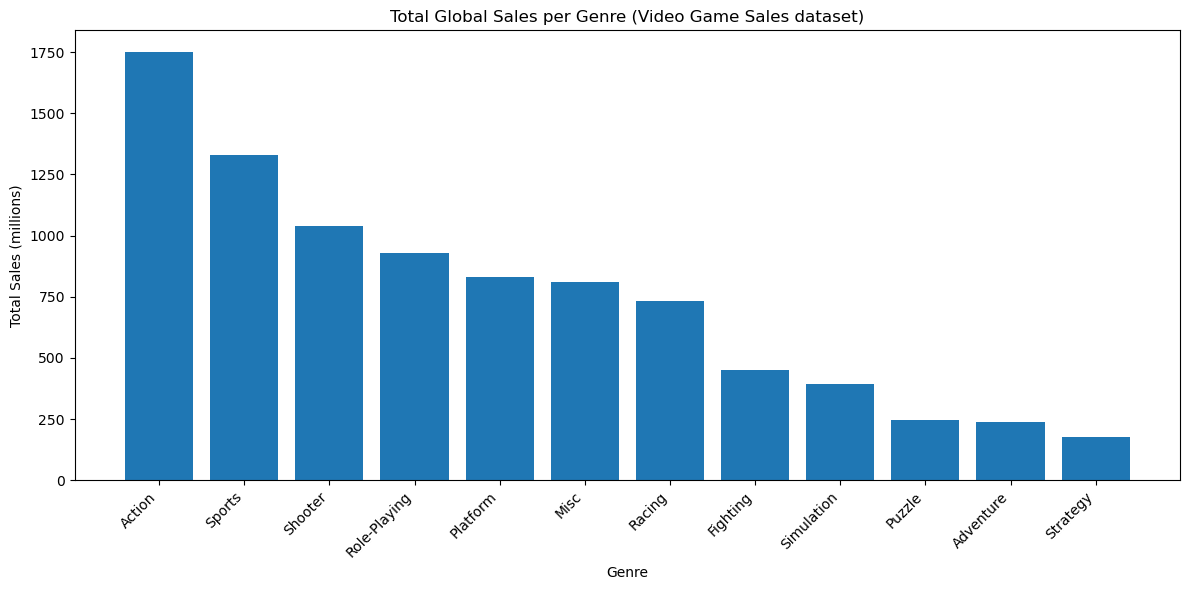

In [48]:
# Totaal verkoop per genre op basis van de volledige sales-dataset
sales_per_genre_full = (
    sales_clean
    .groupBy("Genre")
    .agg(spark_sum("Global_Sales").alias("total_sales"))
    .orderBy("total_sales", ascending=False)
)

# Naar pandas voor plotting
sales_genre_pdf = sales_per_genre_full.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(sales_genre_pdf["Genre"], sales_genre_pdf["total_sales"])
plt.title("Total Global Sales per Genre (Video Game Sales dataset)")
plt.xlabel("Genre")
plt.ylabel("Total Sales (millions)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Interpretatie – Total Global Sales per Genre (Video Game Sales dataset)

- Deze visualisatie toont de **totale globale verkoopcijfers per genre**, onafhankelijk van Steam.  
- **Action** is veruit het sterkst verkochte genre, gevolgd door **Sports**, **Shooter**, en **Role-Playing**.  
- Genres zoals **Puzzle**, **Adventure** en **Strategy** hebben aanzienlijk lagere totale verkoopcijfers.  
- Dit bevestigt een klassieke trend in de gamingindustrie:  
  **grootschalige, actiegerichte titels domineren commercieel**, terwijl nichegenres wel populair kunnen zijn maar minder omzet genereren.  
- In vergelijking met de reviewanalyse toont dit opnieuw dat **wat commercieel succesvol is niet automatisch het hoogst gewaardeerd wordt door spelers**.s.


## Best rated genres

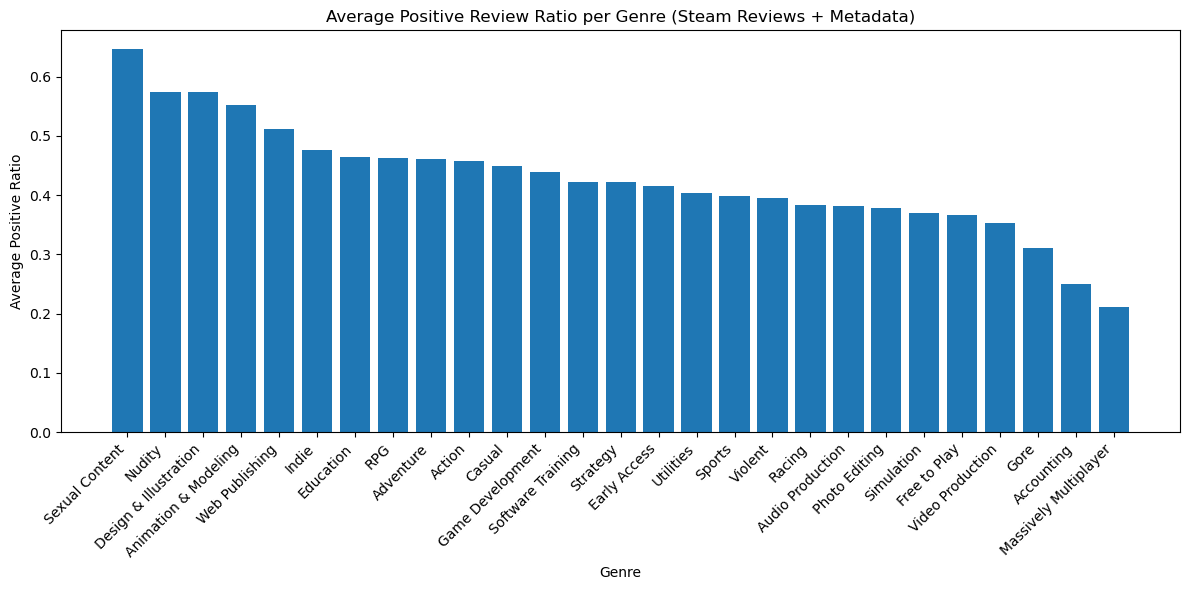

In [49]:
# 3) Genres opsplitsen en exploden
reviews_genres = (
    reviews_with_metadata
    .withColumn("genre_split", split(col("genres"), ";"))
    .withColumn("genre", explode(col("genre_split")))
    .select("genre", "positive_ratio")
)

# 4) Gemiddelde positive_ratio per genre
avg_ratio_per_genre_full = (
    reviews_genres
    .groupBy("genre")
    .agg({"positive_ratio": "avg"})
    .withColumnRenamed("avg(positive_ratio)", "avg_positive_ratio")
    .orderBy("avg_positive_ratio", ascending=False)
)

# Naar pandas voor plotting
genre_ratio_pdf = avg_ratio_per_genre_full.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(genre_ratio_pdf["genre"], genre_ratio_pdf["avg_positive_ratio"])
plt.title("Average Positive Review Ratio per Genre (Steam Reviews + Metadata)")
plt.xlabel("Genre")
plt.ylabel("Average Positive Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



#### Interpretatie – Average Positive Review Ratio per Genre (Steam Reviews + Metadata)

- De grafiek toont de **gemiddelde positieve reviewratio per genre** op Steam.  
- Genres zoals **Sexual Content**, **Nudity**, **Design & Illustration**, en **Animation & Modeling** scoren opvallend hoog — vaak omdat deze niches **kleine maar zeer positieve communities** hebben.  
- Genres zoals **Indie**, **Adventure**, **RPG** en **Action** scoren gemiddeld en reflecteren grotere doelgroepen met diversere meningen.  
- Genres zoals **Violent**, **Gore**, **Accounting** en **Massively Multiplayer** scoren lager, wat kan wijzen op hogere verwachtingen of meer variatie in kwaliteit.  
- De resultaten tonen dat **reviews sterk genre-afhankelijk zijn**, en dat commerciële topgenres niet altijd de hoogste waardering krijgen.en.


## Correlatie: reviews & verkoop

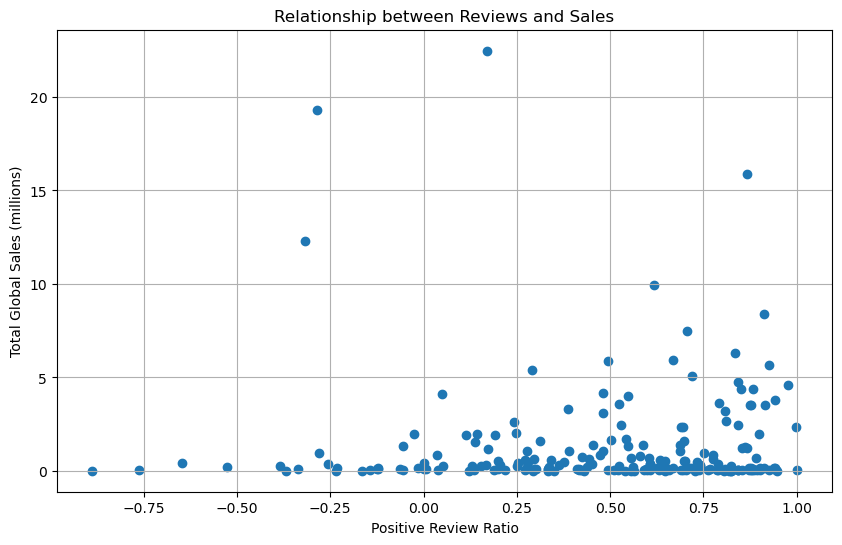

In [29]:
plt.figure(figsize=(10,6))
plt.scatter(pdf['positive_ratio'], pdf['total_global_sales'])
plt.xlabel('Positive Review Ratio')
plt.ylabel('Total Global Sales (millions)')
plt.title('Relationship between Reviews and Sales')
plt.grid(True)
plt.show()


#### Interpretatie – Positive ratio vs Total Global Sales

- Dplotlk toont **geen duidelijke lineaire relatie** tussen `positive_ratio` en `total_global_sales`.
- Games met hoge verkopen hebben niet noodzakelijk de hoogste review-ratio, en omgekeerd.
- Dit ondersteunt de conclusie dat **spelerstevredenheid op Steam geen sterke voorspeller is van commerciële wereldwijde veprkoo**.


## price vs rating

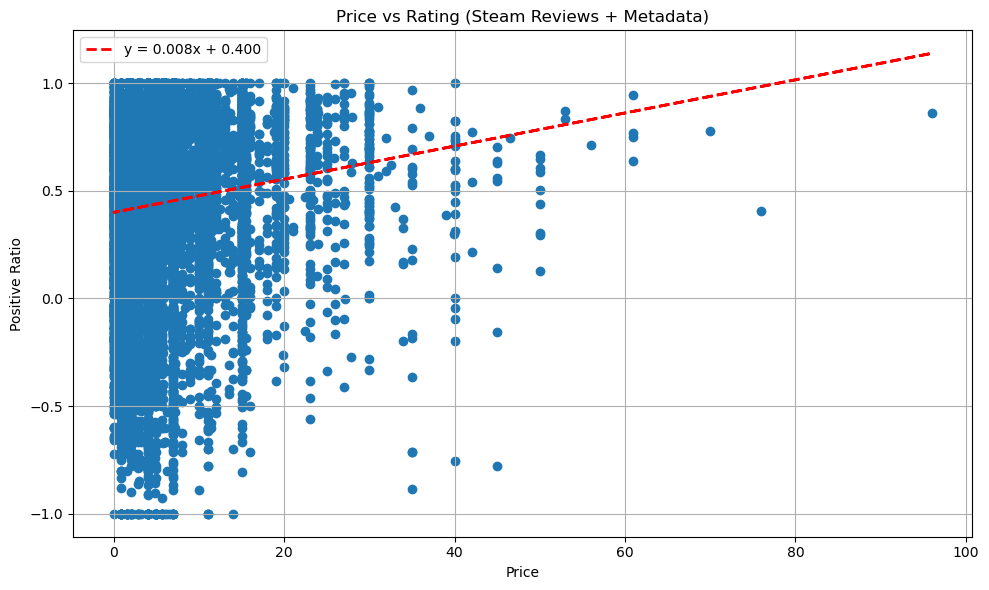

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Filter op niet-lege prijzen en geldige ratios
reviews_meta_price = reviews_with_metadata.filter(
    (col("price").isNotNull()) & (col("positive_ratio").isNotNull())
)

# Naar pandas
price_rating_pdf = reviews_meta_price.select("price", "positive_ratio").toPandas()

# outliers filteren (bv. prijzen > 100 negeren)
price_rating_pdf = price_rating_pdf[price_rating_pdf["price"] <= 100]

# Scatter + regressielijn
plt.figure(figsize=(10, 6))

# Scatter
plt.scatter(price_rating_pdf["price"], price_rating_pdf["positive_ratio"])

# Regressielijn
z = np.polyfit(price_rating_pdf["price"], price_rating_pdf["positive_ratio"], 1)
p = np.poly1d(z)
plt.plot(
    price_rating_pdf["price"],
    p(price_rating_pdf["price"]),
    "r--",
    linewidth=2,
    label=f"y = {z[0]:.3f}x + {z[1]:.3f}"
)

plt.xlabel("Price")
plt.ylabel("Positive Ratio")
plt.title("Price vs Rating (Steam Reviews + Metadata)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Interpretatie – Price vs Rating (Steam Reviews + Metadata)

- Deze scatterplot toont het verband tussen de prijs van een game en de positieve reviewratio op Steam.  
- De regressielijn heeft een **lichte positieve helling (~0.008)**, maar de puntenwolk is zeer verspreid.  
- Er is **geen duidelijk lineair verband**: zowel goedkope als dure games kunnen hoge of lage reviewratio’s hebben.  
- Dit bevestigt dat **prijs geen bepalende factor** is voor spelerstevredenheid.  
- De bevinding sluit aan bij de correlatiematrix: reviewratio en prijs zijn **praktisch onafhankelijk**.

## Sales per year

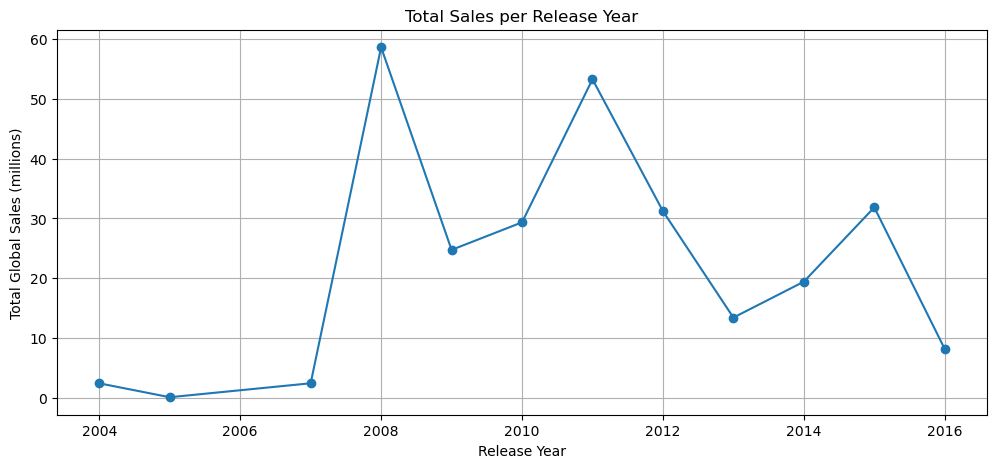

In [31]:
year_sales = pdf.groupby('release_year')['total_global_sales'].sum()

plt.figure(figsize=(12,5))
year_sales.plot(kind='line', marker='o')
plt.title('Total Sales per Release Year')
plt.xlabel('Release Year')
plt.ylabel('Total Global Sales (millions)')
plt.grid(True)
plt.show()


#### Interpretatie – Total Sales per Release Year (subset matched games)

- Binnen de subset van 208 gematchte games zien we duidelijke pieken in bepaalde jaren (o.a. rond 2008 en 2011), die overeenkomen met periodes waarin veel grote AAA-titels uitkwamen.
- Omdat dit enkel de games zijn die zowel in Steam als in de verkoopdataset voorkomen, is dit **geen volledig beeld van de hele markt**, maar het toont wel dat de meest verkochte titels geconcentreerd zijn in een beperkt aantal releasejarn.


### Sales per year (only Video Game Sales dataset)

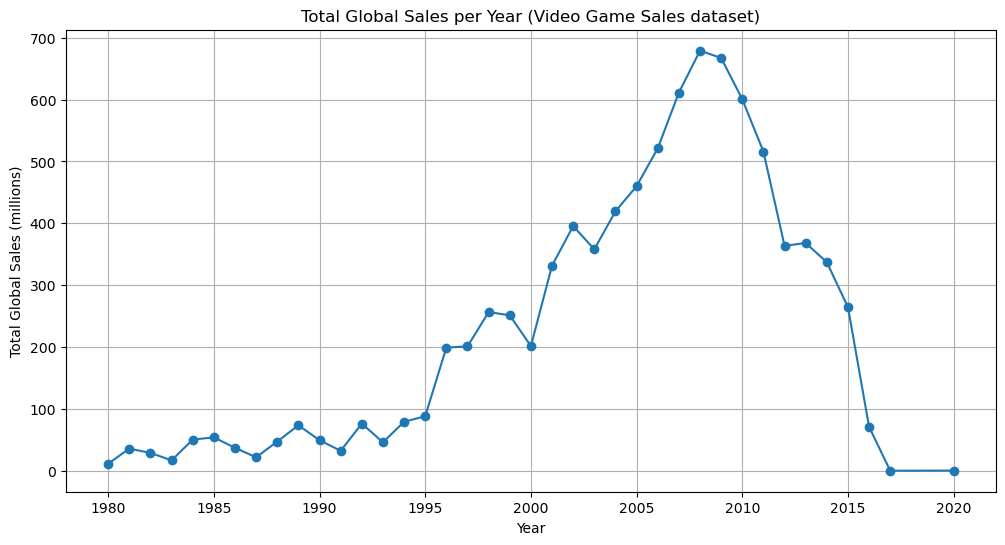

In [32]:
# Pandas dataframe maken
sales_pdf = sales_clean.select("Year", "Global_Sales").toPandas()

# Onbekende jaren droppen
sales_pdf = sales_pdf.dropna(subset=["Year"])

# Aggregatie in Pandas
sales_year = sales_pdf.groupby("Year")["Global_Sales"].sum()

# Plotten
plt.figure(figsize=(12,6))
sales_year.plot(kind='line', marker='o')
plt.title("Total Global Sales per Year (Video Game Sales dataset)")
plt.xlabel("Year")
plt.ylabel("Total Global Sales (millions)")
plt.grid(True)
plt.show()

#### Interpretatie – Total Global Sales per Year (volledige Video Game Sales dataset)

- De fysieke wereldwijde gameverkoop stijgt geleidelijk vanaf de jaren ’80 en bereikt een duidelijke piek tussen **2005 en 2009**, in de periode van consoles zoals de Xbox 360, PlayStation 3 en Nintendo Wii.
- Na 2010 zien we een scherpe daling. Dit komt niet door een instortende markt, maar door de **overschakeling van fysieke verkoop naar digitale platformen** (Steam, PSN, Xbox Live) die in deze dataset niet worden meegerekend.
- Vanaf 2017 zakken de waarden bijna tot nul, wat vooral aangeeft dat deze dataset **geen moderne digitale verkoop** bevat en dus niet representatief is voor de recente videogamemarkt.
- Deze visualisatie geeft daardoor vooral inzicht in de **historische evolutie van fysieke gameverkoop**, en dient vooral als context, niet als directe vergelijking met de Steam-subset die we in dit project analysren.


## Top 10 games (Sales)

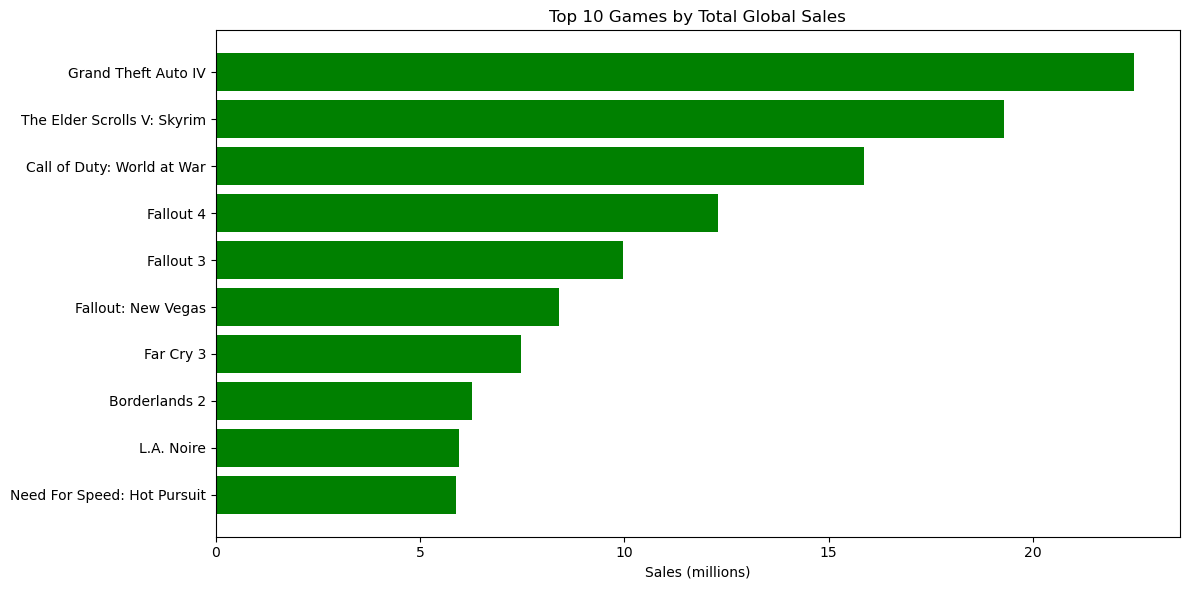

In [33]:
top10 = pdf.sort_values('total_global_sales', ascending=False).head(10)

plt.figure(figsize=(12,6))
plt.barh(top10['steam_name'], top10['total_global_sales'], color='green')
plt.title('Top 10 Games by Total Global Sales')
plt.xlabel('Sales (millions)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Interpretatie – Top 10 Games by Total Global Sales

- De top 10 wordt aangevoerd door grote namen zoals **Grand Theft Auto IV, The Elder Scrolls V: Skyrim, Call of Duty: World at War, Fallout 4, Fallout 3** enz.
- Dit zijn bijna allemaal bekende **AAA-franchises** met sterke merkwaarde, grote marketingbudgetten en multi-platform releases.
- In combinatie met de reviewdata kan ik bekijken of deze toppers ook hoog scoren op tevredenheid, of eerder “blockbusters met gemengde reviews” zjn.


# Extra

In [34]:
print("Oldest subset release: ",pdf['release_year'].min())
print("newest subset release: ",pdf['release_year'].max())

Oldest subset release:  2004
newest subset release:  2016


## correlatie matrix

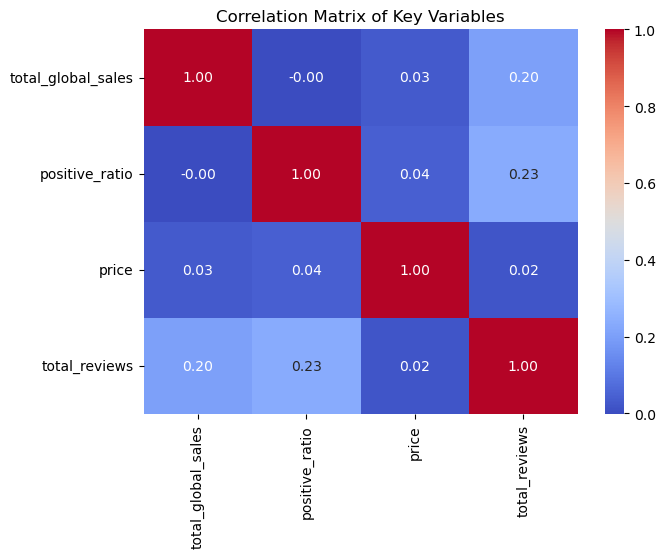

In [35]:
corr = pdf[['total_global_sales','positive_ratio','price','total_reviews']].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Variables")
plt.show()

#### Conclusie – Correlatiematrix

- De correlatiematrix toont dat:
  - `total_global_salenietjks correleert met `positive_ratio` (bijna 0),
  - er ook geen sterk verband is tussen `price` en `positive_ratio`,
  - het aantal `total_reviews` wel iets zegt over populariteit, maar niet rechtstreeks over verkoop.
- Dit bevestigt de eerdere observaties uit de scatterplots: **reviews, prijs en verkoop zijn in deze subset slechts zwak met elkaar verbonden**.
- Commercieel succes lijkt dus vooral bepaald te worden door andere factoren (franchise, marketing, platform, etc.) die niet volledig in deze datasets itten.


# Eindconclusie

In dit project heb ik met Apache Spark drie verschillende bronnen – **Steam Reviews**, **Steam Metadata** en **Video Game Sales** – samengebracht en geanalyseerd. Via datacleaning, typeconversies, naam-normalisatie en joins op titel én releasejaar werd een geïntegreerde subset van **208 games** opgebouwd waarvoor zowel reviewgegevens, metadata als verkoopcijfers beschikbaar zijn (periode **2004–2016**).

Uit de **Video Game Sales dataset (volledige markt)** blijkt dat de commerciële sector sterk gedomineerd wordt door genres zoals **Action**, **Sports**, **Shooter** en **RPG**. Dit weerspiegelt de voorkeur van de massamarkt en de sterke aanwezigheid van AAA-franchises binnen deze genres.

Wanneer we kijken naar **gebruikersbeoordelingen op Steam (Reviews + Metadata)** zien we echter een ander patroon: genres zoals **Indie**, **Adventure**, **Casual** en sommige niche-genres scoren gemiddeld **veel hogere positieve reviewratio’s**. Dit toont dat wat commercieel populair is, niet noodzakelijk het meest geliefd is bij spelers.

Daarnaast tonen de scatterplots en de correlatiematrix op de 208 matched games dat er **nauwelijks lineaire verbanden** bestaan tussen:
- de **positieve reviewratio** en de **totale verkoop**,  
- de **prijs** van een game en de **gemiddelde beoordeling**.

Zowel dure als goedkope games kunnen uitstekende of slechte reviews hebben, en sterk verkopende games zijn niet automatisch de best beoordeelde titels. De sterkste verkooptoppers zijn vooral bekende **AAA-franchises** (GTA, Skyrim, Call of Duty, Fallout, …), wat suggereert dat **marketing, merkbekendheid en platformstrategie** een belangrijkere rol spelen dan prijs of reviewkwaliteit – factoren die niet zichtbaar zijn in de beschikbare data.

Een belangrijke beperking van deze studie is dat diepere correlatie-analyses enkel uitgevoerd kunnen worden op de **subset waarvoor alle drie de datasets elkaar overlappen**. Deze 208 games vormen geen volledig beeld van de markt, maar wel een realistische en kwalitatieve subset van grote multi-platform releases. Dit weerspiegelt typische uitdagingen in data science-projecten: onvolledige joins, naamverschillen en ontbrekende data maken deel uit van de praktijk.

Samengevat tonen de resultaten dat **spelerstevredenheid, prijs en commercieel succes nauwelijks rechtstreeks met elkaar verbonden zijn**. Wat Steam-gebruikers het best beoordelen, is niet noodzakelijk wat wereldwijd het meest verkoopt – en commerciële toppers zijn niet automatisch de meestgeliefde games.
ebruikers.